### Import Libraries

In [10]:
# Import fungsi time untuk mendapatkan nilai waktu mulai eksekusi
import time
a = time.time()
# Import fungsi matematika
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Import fungsi Operating System Directory
import os
from __future__ import print_function, division
from builtins import range, input
# Install and/or Import TF dan Keras & show version
# !pip install tensorflow
# !pip install keras
import tensorflow as tf
from tensorflow import keras
print('Tensorflow version : ', tf.__version__)
print('Keras version : ', keras.__version__)
# Import Pre-trained Model Xception
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
# from keras.applications.xception import Xception
# from keras.applications.xception import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
# Import fungsi untuk Confusion Matrix dan Plot Grafik
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from glob import glob

Tensorflow version :  2.9.1
Keras version :  2.9.0


### Explore Data

Training files and Classes
Found 10829 files belonging to 4 classes.
Testing files and Classes
Found 1000 files belonging to 4 classes.


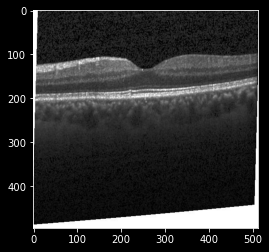

In [11]:
# Explore Dataset
# from random import shuffle

# Set to Current Working Directory
cwd = os.getcwd()
PATH = os.path.join(cwd, 'OCTOne-tenth')

# Set to train dir and show number of files
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'test')

BATCH_SIZE = 32
IMG_SIZE = [160, 160]

print('Training files and Classes')
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

print('Testing files and Classes')
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

#Split training set to 50%, 25%, or 10% for faster experimental training

#Show random training images
random = glob(train_dir + '/*/*.jp*g')
plt.imshow(keras.utils.load_img(np.random.choice(random)))
plt.show()

In [12]:
#Take 20 % of test set data for validation
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


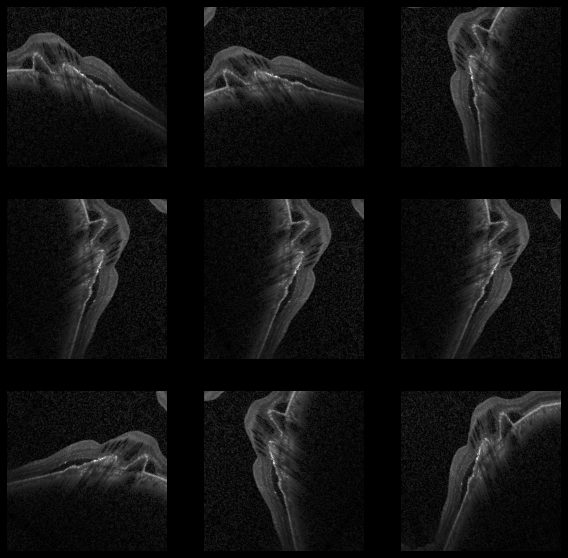

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

# Show random augmented images
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [15]:
preprocess_input = tf.keras.applications.xception.preprocess_input


rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# create a model object
IMG_SHAPE = IMG_SIZE + [3]
base_model = tf.keras.applications.Xception(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False

# view the structure of the model
base_model.summary()

83683744/83683744 [==============================] - 7s 0us/step
(32, 5, 5, 2048)
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 79, 79, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
         

### Loss and Optimization functions

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [17]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
# tell the model what cost and optimization method to use
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
  metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [21]:
len(model.trainable_variables)

2

In [91]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
""" test_gen = ImageDataGenerator().flow_from_directory(test_dir, target_size=IMG_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k """

# should be a strangely colored image (due to VGG weights being BGR)
#for x, y in test_gen:
#    print("min:", x[0].min(), "max:", x[0].max())
#    plt.title(labels[np.argmax(y[0])])
#    plt.imshow(x[0])
#    plt.show()
#    break

Found 1000 images belonging to 4 classes.
{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


In [22]:
# training config:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 21s 748ms/step - loss: 1.7822e-07 - accuracy: 0.2475


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.00
initial accuracy: 0.25


In [24]:
# fit the model
history = model.fit(
  train_dataset,
  epochs=initial_epochs,
  validation_data=validation_dataset
)

Epoch 1/10
339/339 [==============================] - 278s 813ms/step - loss: 2.0033e-07 - accuracy: 0.2925 - val_loss: 1.7808e-07 - val_accuracy: 0.2525
Epoch 2/10
339/339 [==============================] - 268s 791ms/step - loss: 2.0033e-07 - accuracy: 0.2927 - val_loss: 1.7675e-07 - val_accuracy: 0.2611
Epoch 3/10
339/339 [==============================] - 271s 799ms/step - loss: 2.0033e-07 - accuracy: 0.2896 - val_loss: 1.7690e-07 - val_accuracy: 0.2562
Epoch 4/10
339/339 [==============================] - 269s 793ms/step - loss: 2.0033e-07 - accuracy: 0.2938 - val_loss: 1.7852e-07 - val_accuracy: 0.2512
Epoch 5/10
339/339 [==============================] - 269s 794ms/step - loss: 2.0033e-07 - accuracy: 0.2942 - val_loss: 1.7572e-07 - val_accuracy: 0.2537
Epoch 6/10
339/339 [==============================] - 268s 791ms/step - loss: 2.0033e-07 - accuracy: 0.2939 - val_loss: 1.7749e-07 - val_accuracy: 0.2562
Epoch 7/10
339/339 [==============================] - 268s 792ms/step - loss

KeyboardInterrupt: 

In [ ]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
        i += 1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break
    cm = confusion_matrix(targets, predictions)
    return cm


cm = get_confusion_matrix(train_path, len(train_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)




Generating confusion matrix 10829
Found 10829 images belonging to 4 classes.
2/2 [==============================] - 1s 565ms/step
50
2/2 [==============================] - 1s 565ms/step
100
2/2 [==============================] - 1s 563ms/step
150
1/1 [==============================] - 0s 315ms/step
[[3268  111  116  225]
 [ 153  564   36  381]
 [ 149   37  339  336]
 [ 196  184  189 4545]]
Generating confusion matrix 1000
Found 1000 images belonging to 4 classes.
2/2 [==============================] - 1s 151ms/step
[[227  14   1   8]
 [ 60 145   3  42]
 [ 74  19  46 111]
 [  9  16  11 214]]


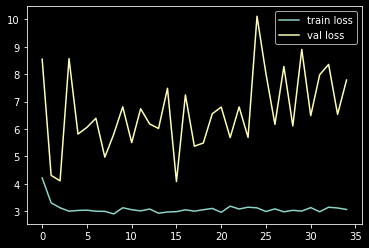

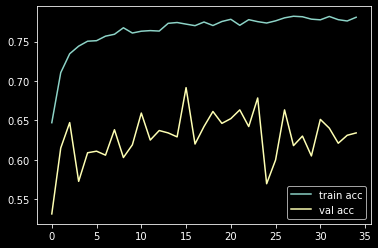

In [ ]:
# plot Loss and Accuracies

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


Confusion matrix, without normalization
[[3268  111  116  225]
 [ 153  564   36  381]
 [ 149   37  339  336]
 [ 196  184  189 4545]]


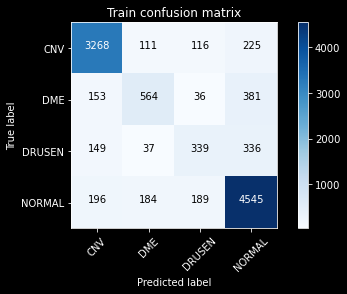

Confusion matrix, without normalization
[[227  14   1   8]
 [ 60 145   3  42]
 [ 74  19  46 111]
 [  9  16  11 214]]


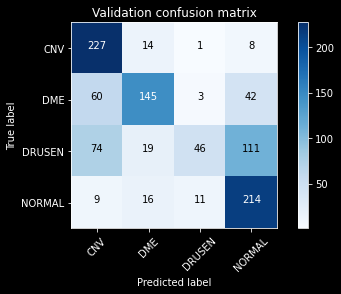

In [ ]:
# Plot Confusion Matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

In [ ]:
b = time.time()
print("time: ", b - a)

time:  8159.5495393276215
